In [21]:
import numpy as np
import matplotlib.pyplot as plt

import h5py

In [22]:
file = '/Users/straniero/Documents/Dphil/data_SPS/SPS.BQHT_MD4_20181108_222234.h5'

In [23]:
with h5py.File(file, 'r') as f:
    vert_delta = f['vertical/delta'][:]   
    horiz_delta = f['horizontal/delta'][:]
    horiz_sigma = f['horizontal/sigma'][:]
    vert_sigma = f['vertical/sigma'][:]

In [4]:
position_x_centroid = horiz_delta/horiz_sigma

/var/folders/8n/d7x4lr8x0px2lfcpk_mn54kw0000gp/T/ipykernel_32186/1960951314.py:1: RuntimeWarning: divide by zero encountered in divide
  position_x_centroid = horiz_delta/horiz_sigma


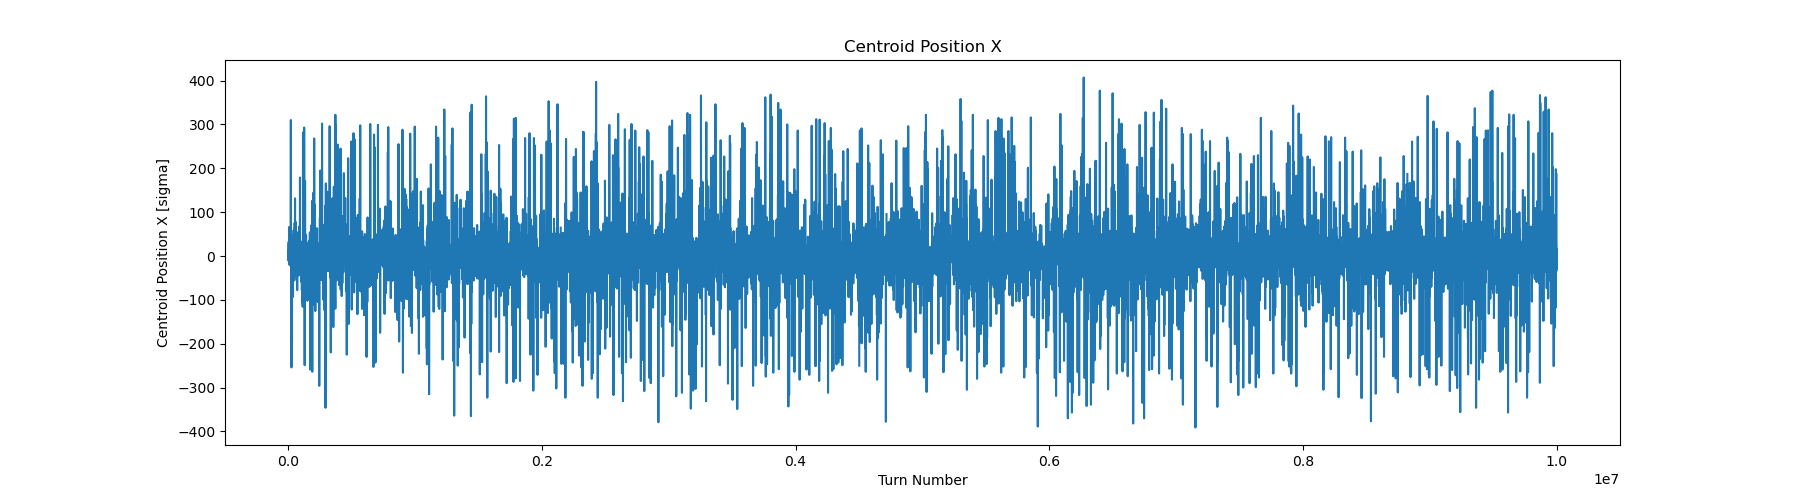

In [5]:
%matplotlib widget

plt.figure(figsize=(18,5))
plt.plot(position_x_centroid)
plt.title('Centroid Position X')
plt.xlabel('Turn Number')
plt.ylabel('Centroid Position X [sigma]')
plt.show()

In [ ]:
centroid_split = np.empty((10000,1000))
for i in range(10000):
    centroid_split[i,:] = position_x_centroid[i*1000:(i+1)*1000]

In [ ]:
%matplotlib widget
plt.figure(figsize=(18,5))
for i in range(500):
    plt.plot(centroid_split[i*20,:], alpha=0.3)

In [ ]:
import matplotlib.animation as animation
%matplotlib ipympl

fig2, ax = plt.subplots(figsize=(18, 6))
graph, = ax.plot(centroid_split[0, :])
ax.set_title("centroid position X evolution")
# Add a text box to display the frame number
frame_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, fontsize=12,
                     bbox=dict(facecolor='white', alpha=0.7))
#Set axes limits
ax.set_ylim(-300, 300)
def update(frame):
    graph.set_ydata(centroid_split[frame*20, :])
    frame_text.set_text(f'Loop: {frame*20}')
    return graph, frame_text

ani = animation.FuncAnimation(fig2, update, frames=range(0,500), blit=False, interval=50, repeat=False)

#ani.save('vertical_sigma_evolution.mp4', writer='ffmpeg', fps=20)

In [40]:


def rss_position_from_delta_sigma(delta, sigma, sX, sigma_v, loops, period, type='up'):
    """
    Compute RSS position and uncertainty from Delta and Sigma arrays.

    Inputs:
      delta : 1D numpy array of shape (N,)   -- Δ = S_R - S_L
      sigma : 1D numpy array of shape (N,)   -- Σ = S_R + S_L
      sX    : float                          -- horizontal sensitivity (fraction/% per mm).
                                             # NOTE: supply consistent unit; if sX given as percent/mm (e.g. 2.0 %/mm),
                                             # convert to fraction/mm: sX = 0.02 (i.e. 2% -> 0.02)
      sigma_v : float                        -- RMS noise per ADC sample (same units as delta/sigma)

    Returns:
      x_rss : float          -- RSS position estimator (same length-scale as 1/sX input, e.g. mm)
      sigma_x : float        -- estimated standard uncertainty of x_rss
      details : dict         -- intermediate numbers: RSS_L, RSS_R, N
              """
    if type not in ['up', 'down']:
        raise ValueError("Invalid type. Must be 'up' or 'down'.")
    if type == 'up':
        a = 140
        b = 180
    if type == 'down':
        a = 180
        b = 220
    # Reconstruct S_R and S_L from delta and sigma:
    S_R = 0.5 * (sigma + delta)
    S_L = 0.5 * (sigma - delta)

    #Split the whole data in loops
    S_R_split = np.empty((loops,period))
    for i in range(loops):  
        S_R_split[i,:] = S_R[i*period:(i+1)*period]

    S_L_split = np.empty((loops,period))
    for i in range(loops):  
        S_L_split[i,:] = S_L[i*period:(i+1)*period]

    x_evolution= np.empty(loops)
    sigma_x_evolution = np.empty(loops)
    # Compute RSS of each electrode:
    for i in range(loops):
        
      RSS_R = np.sqrt(np.sum(S_R_split[i,a:b].astype(np.float64) ** 2))
      RSS_L = np.sqrt(np.sum(S_L_split[i,a:b].astype(np.float64) ** 2))

      # position (Eq. (7) in Reiter & Singh)
      num = RSS_R - RSS_L
      den = RSS_R + RSS_L
      if den == 0:
          raise ValueError("RSS_R + RSS_L == 0 (division by zero). Check inputs.")
      x_evolution[i] = (1.0 / sX) * (num / den)

      # uncertainty estimate (propagation assuming sigma_RSS = sigma_v for each RSS)
      RSS_mean = den / 2.0
      # sigma_x ≈ sigma_v / ( sX * sqrt(2) * RSS_mean )
      sigma_x_evolution[i] = sigma_v / (sX * np.sqrt(2.0) * RSS_mean)


    return x_evolution, sigma_x_evolution

# Example usage:
# delta = np.load("delta.npy")   # user-provided arrays, length 10_000_000
# sigma = np.load("sigma.npy")
# sX_percent_per_mm = 2.0  # e.g. 2 %/mm
# sX = sX_percent_per_mm / 100.0   # convert percent to fraction per mm
# sigma_v = 0.001  # example: 1 mV (in same units as delta/sigma)
# x, x_unc, details = rss_position_from_delta_sigma(delta, sigma, sX, sigma_v)
# print("x_RSS = {:.6f} mm  ± {:.6f} mm".format(x, x_unc))
# print(details)


In [ ]:
x_centroid, sigma_x_c = rss_position_from_delta_sigma(vert_delta, vert_sigma, 0.02, 100,loops=10000,period=1000)

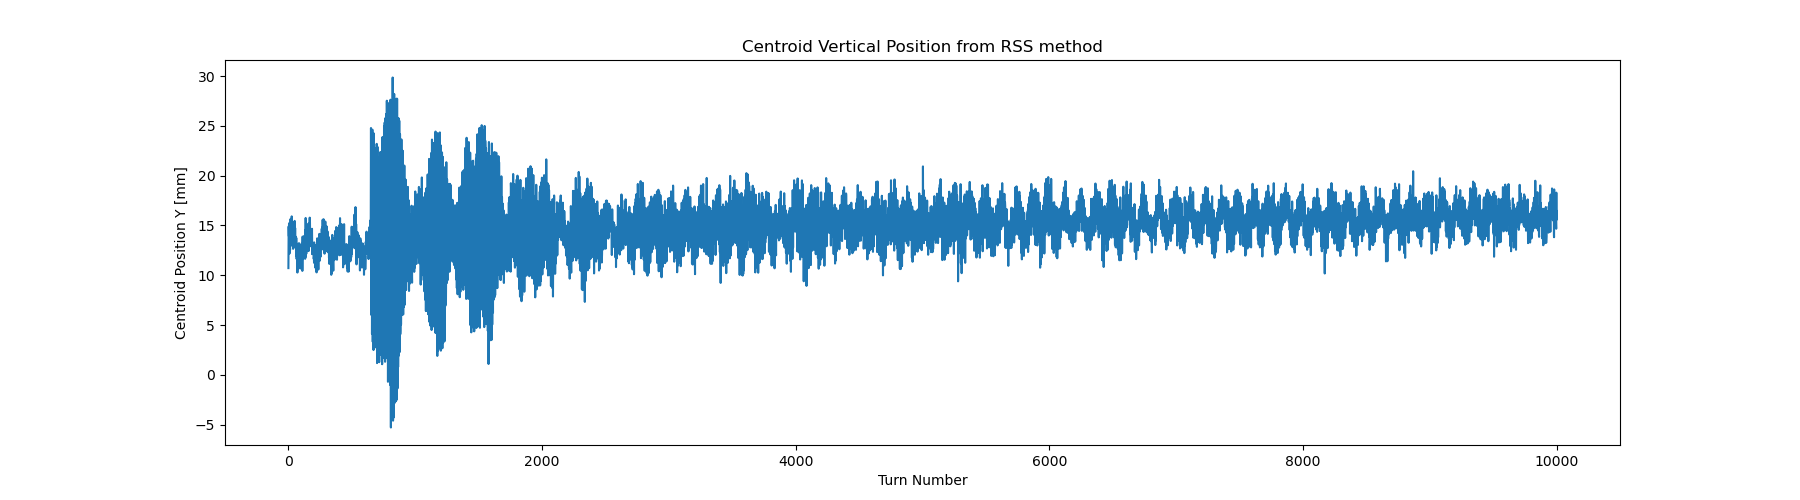

In [47]:
%matplotlib widget
plt.figure(figsize=(18,5))
plt.plot(x_centroid)
plt.title('Centroid Vertical Position from RSS method')
plt.xlabel('Turn Number')
plt.ylabel('Centroid Position Y [mm]')
plt.show()

In [45]:
centroid_RSS_down, sigma_x_c = rss_position_from_delta_sigma(vert_delta, vert_sigma, 0.02, 100,loops=10000,period=1000, type='down')

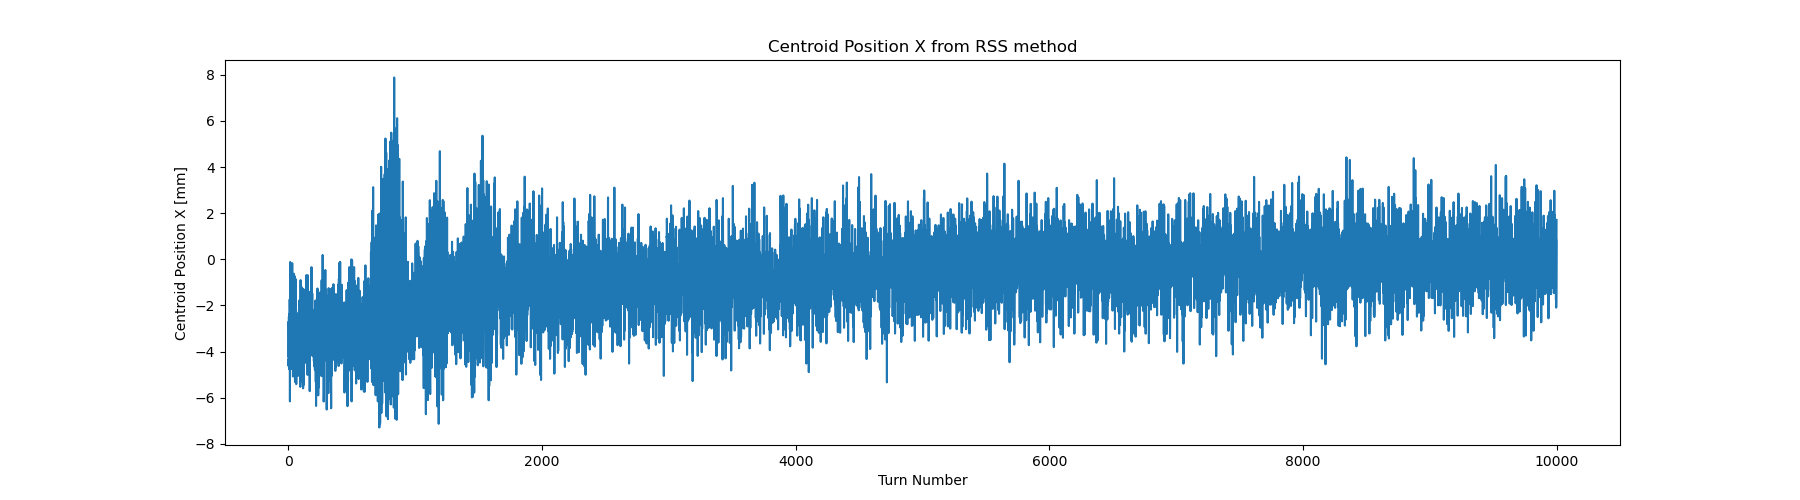

In [46]:
%matplotlib widget
plt.figure(figsize=(18,5))
plt.plot(centroid_RSS_down)
plt.title('Centroid Position X from RSS method')
plt.xlabel('Turn Number')
plt.ylabel('Centroid Position X [mm]')
plt.show()

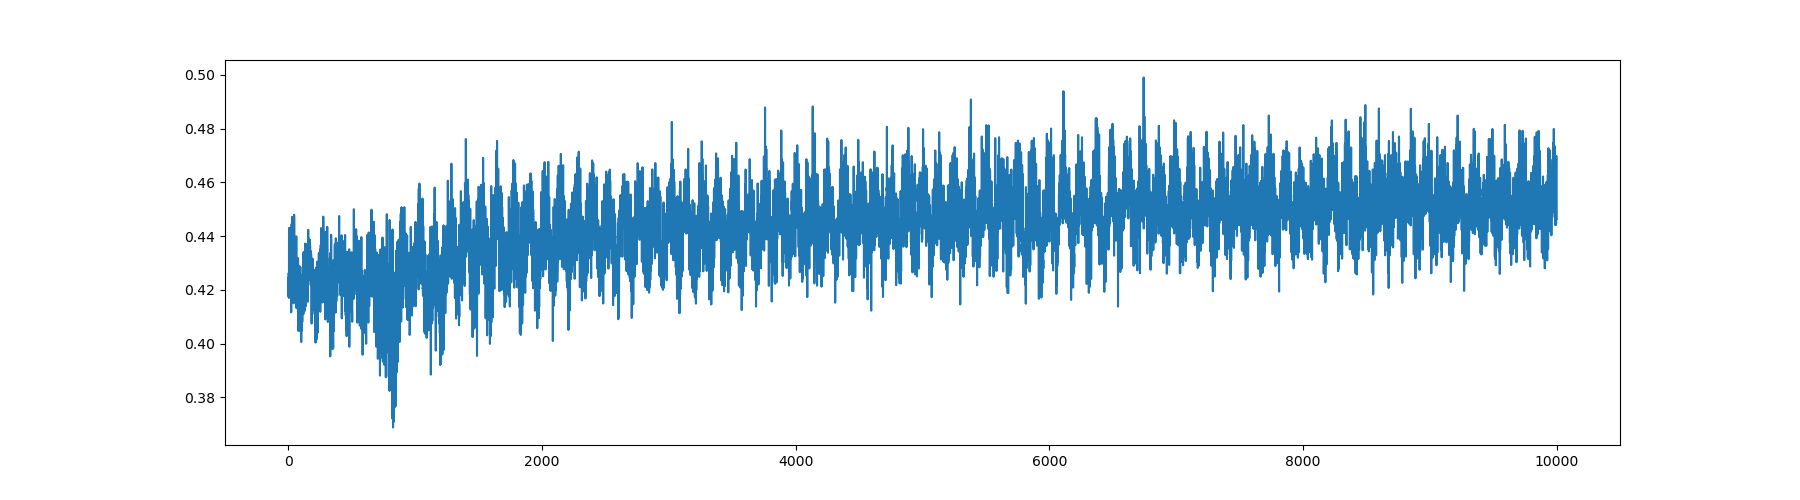

In [28]:
%matplotlib widget
plt.figure(figsize=(18,5))
plt.plot(sigma_x_c)

## STANDARD DEVIATION METHOD

In [13]:
def std_position_from_delta_sigma(delta, sigma, sX, sigma_v, loops, period):
    """
    Compute RSS position and uncertainty from Delta and Sigma arrays.

    Inputs:
      delta : 1D numpy array of shape (N,)   -- Δ = S_R - S_L
      sigma : 1D numpy array of shape (N,)   -- Σ = S_R + S_L
      sX    : float                          -- horizontal sensitivity (fraction/% per mm).
                                             # NOTE: supply consistent unit; if sX given as percent/mm (e.g. 2.0 %/mm),
                                             # convert to fraction/mm: sX = 0.02 (i.e. 2% -> 0.02)
      sigma_v : float                        -- RMS noise per ADC sample (same units as delta/sigma)

    Returns:
      x_rss : float          -- RSS position estimator (same length-scale as 1/sX input, e.g. mm)
      sigma_x : float        -- estimated standard uncertainty of x_rss
    """
    # Reconstruct S_R and S_L from delta and sigma:
    S_R = 0.5 * (sigma + delta)
    S_L = 0.5 * (sigma - delta)

    #Split the whole data in loops
    S_R_split = np.empty((loops,period))
    for i in range(loops):  
        S_R_split[i,:] = S_R[i*period:(i+1)*period]

    S_L_split = np.empty((loops,period))
    for i in range(loops):  
        S_L_split[i,:] = S_L[i*period:(i+1)*period]

    x_evolution= np.empty(loops)
    sigma_x_evolution = np.empty(loops)
    # Compute RSS of each electrode:
    for i in range(loops):
        
      STD_R = np.std(S_R_split[i,140:180].astype(np.float64))
      STD_L = np.std(S_L_split[i,140:180].astype(np.float64))

      # position (Eq. (7) in Reiter & Singh)
      num = STD_R - STD_L
      den = STD_R + STD_L
      if den == 0:
          raise ValueError("STD_R + STD_L == 0 (division by zero). Check inputs.")
      x_evolution[i] = (1.0 / sX) * (num / den)

      # uncertainty estimate (propagation assuming sigma_STD = sigma_v for each STD)
      STD_mean = den / 2.0
      # sigma_x ≈ sigma_v / ( sX * sqrt(2) * STD_mean )
      sigma_x_evolution[i] = sigma_v / (sX * np.sqrt(2.0) * STD_mean)

    
    return x_evolution, sigma_x_evolution


In [24]:
x_STD, sigma_x_s = std_position_from_delta_sigma(vert_delta, vert_sigma, 0.02, 100,loops=10000,period=1000)

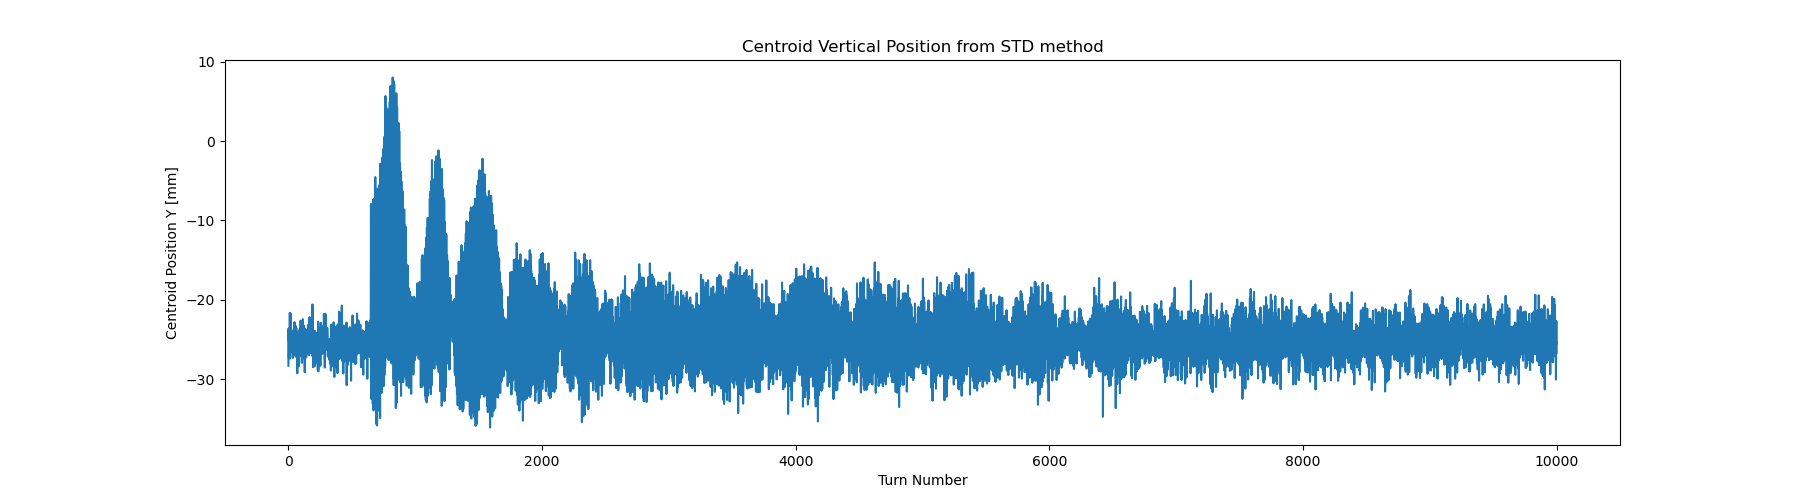

In [48]:
%matplotlib widget
plt.figure(figsize=(18,5))
plt.title('Centroid Vertical Position from STD method')
plt.xlabel('Turn Number')
plt.ylabel('Centroid Position Y [mm]')
plt.plot(x_STD)